<a href="https://colab.research.google.com/github/danielNorbitt/iara-tcc/blob/main/Iara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis

## Import Packages

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import nltk


## Download NLTK resources if not already downloaded

In [ ]:
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Load Data

In [ ]:
df = pd.read_csv("gov.csv")
df["text"] = df["text"].str.lower()

# Load substitution words from CSV
substitution_words_df = pd.read_csv("words.csv")
words_to_substitute = substitution_words_df["word"].tolist()

# Load stopwords from CSV
# stopwords_df = pd.read_csv("~/Documents/Profissional/Pesquisa/Artigos/Parlamentares/Data/MySWl.csv")
# custom_stopwords = stopwords_df["word"].tolist()
df

,Nome Completo,Nome Urna,Cargo,Número,Partido,Coligação,Situação,Situação Pós-Pleito,Ano,Estado,text
0,ELTON DE BARROS BRAGA,ELTON BRAGA,Governador,28,PRTB,PRTB,Deferido,Não eleito,2014,PA,\ncomissão provisória regional do pará ...
1,HELDER ZAHLUTH BARBALHO,HELDER BARBALHO,Governador,15,PMDB,TODOS PELO PARÁ,Deferido,2º turno,2014,PA,1 \n \n \ncoligação “todos pelo pará” \n \n \n...
2,MARCO ANTONIO NASCIMENTO RAMOS,MARCO ANTONIO,Governador,21,PCB,PCB,Indeferido,Não eleito,2014,PA,"1 \n \n \nconstruindo o poder popular, por um ..."
3,MARCO ANTÔNIO CARRERA FERREIRA,MARCO CARRERA,Governador,50,PSOL,FRENTE DE ESQUERDA - MUDANÇA PRA VALER,Deferido,Não eleito,2014,PA,1 \n \nfrente de esquerda mudança pra valer (p...


## Applying the substitutions and deletions


In [ ]:
for word in words_to_substitute:
    df["text"] = df["text"].str.replace(word, "vacina")

# # Apply the personalized stopword list
df["text"] = df["text"].apply(lambda x: " ".join([word for word in x.split() if word not in custom_stopwords]))

# Tokenize the 'text' column and remove punctuation
df["tokens"] = df["text"].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalnum() or word.isdigit()])
df

,Nome Completo,Nome Urna,Cargo,Número,Partido,Coligação,Situação,Situação Pós-Pleito,Ano,Estado,text,tokens
0,ELTON DE BARROS BRAGA,ELTON BRAGA,Governador,28,PRTB,PRTB,Deferido,Não eleito,2014,PA,\ncomissão provisória regional do pará ...,"[comissão, provisória, regional, do, pará, cnp..."
1,HELDER ZAHLUTH BARBALHO,HELDER BARBALHO,Governador,15,PMDB,TODOS PELO PARÁ,Deferido,2º turno,2014,PA,1 \n \n \ncoligação “todos pelo pará” \n \n \n...,"[1, coligação, todos, pelo, pará, programa, de..."
2,MARCO ANTONIO NASCIMENTO RAMOS,MARCO ANTONIO,Governador,21,PCB,PCB,Indeferido,Não eleito,2014,PA,"1 \n \n \nconstruindo o poder popular, por um ...","[1, construindo, o, poder, popular, por, um, b..."
3,MARCO ANTÔNIO CARRERA FERREIRA,MARCO CARRERA,Governador,50,PSOL,FRENTE DE ESQUERDA - MUDANÇA PRA VALER,Deferido,Não eleito,2014,PA,1 \n \nfrente de esquerda mudança pra valer (p...,"[1, frente, de, esquerda, mudança, pra, valer,..."


## Calculations

In [ ]:
all_tokens = [token for sublist in df["tokens"] for token in sublist] # retorna lisa com todos tokens de cada coluna

token_freq_dist = nltk.FreqDist(all_tokens)
print("Total unique tokens:", len(token_freq_dist)) # retorna dicionario com token como chave e sua frequencia

# Define the word for which you want to find collocates
word_of_interest = "vacina"

# Filter collocates related to the word of interest
word_collocates = []

# Only proceed if the word of interest is present in the token frequency distribution
if word_of_interest in token_freq_dist:
    # Compute collocations using log likelihood
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_documents(df["tokens"])

    collocations = finder.score_ngrams(bigram_measures.likelihood_ratio)

    # Filter collocates related to the word of interest
    word_collocates = [(w1, w2, score) for (w1, w2), score in collocations if w1 == word_of_interest or w2 == word_of_interest]

    # Sort collocates by likelihood ratio score
    word_collocates.sort(key=lambda x: x[2], reverse=True)

# Limit collocates to 100 entries
word_collocates = word_collocates[:100]

# Create DataFrame with collocates and statistics
collocates_df = pd.DataFrame(word_collocates, columns=["Word 1", "Word 2", "Score"])
collocates_df["Score"] = collocates_df["Score"].round(2)

collocates_df


Total unique tokens: 4049
     Word 1     Word 2   Score
0        do     vacina  510.33
1         o     vacina  179.75
2        no     vacina  128.31
3    vacina         do   95.43
4    vacina        com   50.76
..      ...        ...     ...
144  vacina       mais    0.05
145  vacina  sociedade    0.03
146       a     vacina    0.01
147  vacina         um    0.01
148  vacina         no    0.00

[149 rows x 3 columns]


## Saving to CSV File

In [21]:
collocates_df.to_csv("output.csv", index=False)

# Plot Graphs

## Import Packages

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400

## PrePan

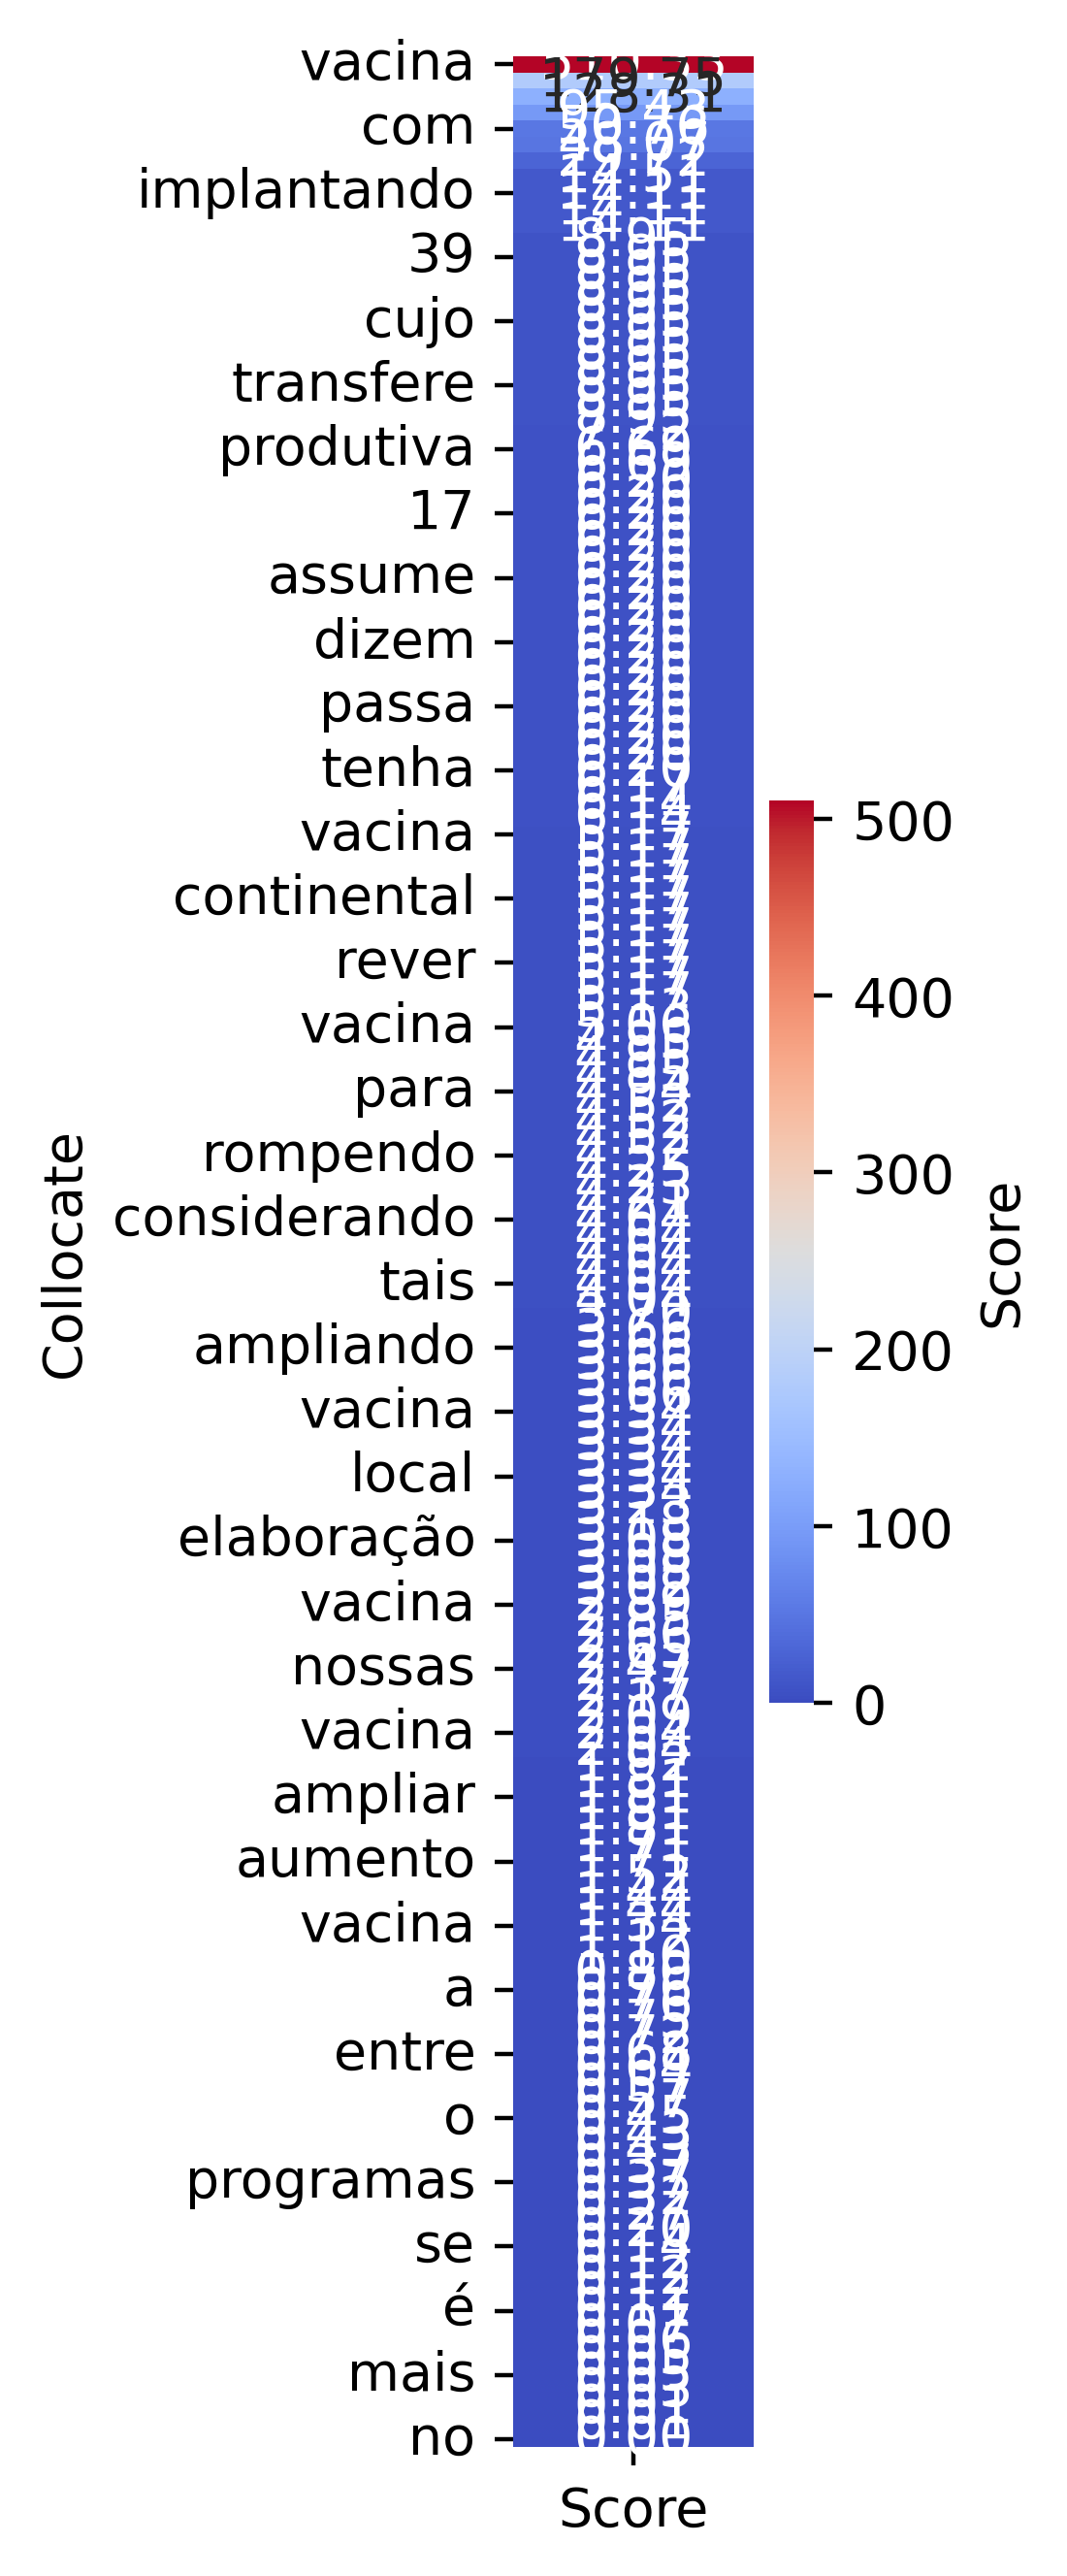

In [23]:
df = pd.read_excel('/home/rll307/Insync/rll307@outlook.com/OneDrive/Documents/Profissional/Pesquisa/Artigos/Parlamentares/Data/Tabela_PrepanArt1CocArt1.xlsx')

# Sort DataFrame by 'Score' column in descending order
df = df.sort_values(by='Score', ascending=False)

# Set 'Collocate' column as index
df.set_index('Collocate', inplace=True)

# Plot heatmap
plt.figure(figsize=(1, 8))
sns.heatmap(df[['Score']], cmap='coolwarm', annot=True, fmt=".2f", linewidths=0, cbar_kws={'orientation': 'vertical', 'label': 'Score'})
plt.xlabel('')  # Remove x-label
plt.ylabel('Collocate')
plt.show()

## NoVac

In [ ]:
# Create DataFrame from given data
df = pd.read_excel('/home/rll307/Insync/rll307@outlook.com/OneDrive/Documents/Profissional/Pesquisa/Artigos/Parlamentares/Data/Tabela_NoVacArt1Coc.ods', engine='odf')

# Sort DataFrame by 'Score' column in descending order
df = df.sort_values(by='Score', ascending=False)

# Set 'Collocate' column as index
df.set_index('Collocate', inplace=True)

# Plot heatmap
plt.figure(figsize=(2, 8))
sns.heatmap(df[['Score']], cmap='coolwarm', annot=True, fmt=".2f", linewidths=0, cbar_kws={'orientation': 'vertical', 'label': 'Score'})
plt.xlabel('')  # Remove x-label
plt.ylabel('Collocate')
plt.show()

## Is Vac

In [ ]:
# Create DataFrame from given data

df = pd.read_excel(
    '/home/rll307/Insync/rll307@outlook.com/OneDrive/Documents/Profissional/Pesquisa/Artigos/Parlamentares/Data/TableIa_VacArt1Coc.xlsx')
# Sort DataFrame by 'Score' column in descending order
df = df.sort_values(by='Score', ascending=False)

# Set 'Collocate' column as index
df.set_index('Collocate', inplace=True)

# Plot heatmap
plt.figure(figsize=(2, 8))
sns.heatmap(df[['Score']], cmap='coolwarm', annot=True, fmt=".2f",
            linewidths=0, cbar_kws={'orientation': 'vertical', 'label': 'Score'})
plt.xlabel('')  # Remove x-label
plt.ylabel('Collocate')
plt.show()